In [59]:
import torch
import torchvision.models as models
from torchvision import transforms
from imagenetv2_pytorch import ImageNetV2Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchattacks
import matplotlib.pyplot as plt
import json

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 1. Custom Dataset Wrapper (same as before)
class PreprocessedImageNetV2(torch.utils.data.Dataset):
    def __init__(self, variant="matched-frequency"):
        self.dataset = ImageNetV2Dataset(variant)
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225]),
        ])
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return self.preprocess(img), label

In [4]:
# 2. Load model and dataset
model = models.resnet18(pretrained=True).to(device).eval()
dataset = PreprocessedImageNetV2("matched-frequency")
dataloader = DataLoader(dataset, batch_size=32, num_workers=4)

/home/hice1/pkutz3/.conda/envs/mls_assignment1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hice1/pkutz3/.conda/envs/mls_assignment1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# 3. Initialize PGD Attack
pgd_attack = torchattacks.PGD(
    model,
    eps=8/255,       # Maximum perturbation (8 pixel intensity)
    alpha=2/255,     # Attack step size
    steps=10,        # Number of attack iterations
    random_start=True # Start from random point in epsilon ball
)

In [6]:
# 4. Evaluation function with adversarial attack
def evaluate_adversarial(model, dataloader, attack):
    clean_correct = 0
    adv_correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        
        # Clean evaluation
        with torch.no_grad():
            outputs = model(images)
            clean_correct += (outputs.argmax(1) == labels).sum().item()
        
        # Generate adversarial examples
        adv_images = attack(images, labels)
        
        # Adversarial evaluation
        with torch.no_grad():
            adv_outputs = model(adv_images)
            adv_correct += (adv_outputs.argmax(1) == labels).sum().item()
        
        total += labels.size(0)
    
    clean_acc = 100 * clean_correct / total
    adv_acc = 100 * adv_correct / total
    return clean_acc, adv_acc

In [7]:
# 5. Run evaluation
print("Evaluating on clean and adversarial images...")
clean_acc, adv_acc = evaluate_adversarial(model, dataloader, pgd_attack)

print(f"\nClean Accuracy: {clean_acc:.2f}%")
print(f"Adversarial Accuracy: {adv_acc:.2f}%")
print(f"Accuracy Drop: {clean_acc - adv_acc:.2f} percentage points")

Evaluating on clean and adversarial images...


Evaluating: 100%|██████████| 313/313 [00:17<00:00, 17.45it/s]


Clean Accuracy: 57.29%
Adversarial Accuracy: 0.20%
Accuracy Drop: 57.09 percentage points


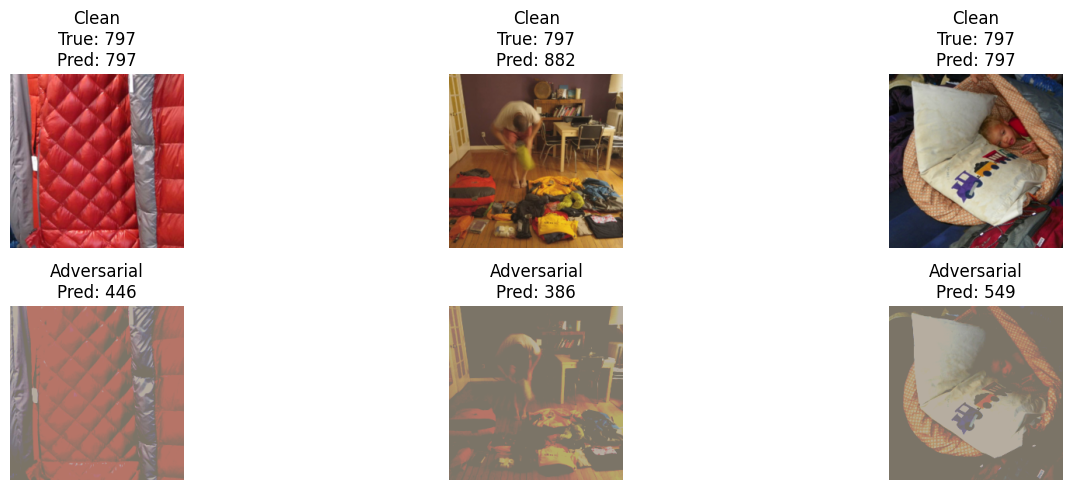

In [11]:
# 6. Visualize examples (optional)
def visualize_attacks(model, dataloader, attack, num_examples=3):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images[:num_examples].to(device), labels[:num_examples].to(device)
    
    # Generate adversarial examples
    adv_images = attack(images, labels)
    
    # Get predictions
    with torch.no_grad():
        clean_preds = model(images).argmax(1)
        adv_preds = model(adv_images).argmax(1)
    
    # Denormalize for visualization
    inverse_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        # Clean image
        plt.subplot(2, num_examples, i+1)
        clean_img = inverse_normalize(images[i]).cpu().permute(1, 2, 0)
        plt.imshow(clean_img.clamp(0, 1))
        plt.title(f"Clean\nTrue: {labels[i].item()}\nPred: {clean_preds[i].item()}")
        plt.axis('off')
        
        # Adversarial image
        plt.subplot(2, num_examples, i+num_examples+1)
        adv_img = inverse_normalize(adv_images[i]).cpu().permute(1, 2, 0)
        plt.imshow(adv_img.clamp(0, 1))
        plt.title(f"Adversarial\nPred: {adv_preds[i].item()}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Uncomment to visualize
visualize_attacks(model, dataloader, pgd_attack)

In [51]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, datasets

In [42]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Grad-CAM calculation
        weights = F.adaptive_avg_pool2d(self.gradients, 1)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, x.shape[2:], mode='bilinear', align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam.squeeze().cpu().detach()

In [60]:
# Get ImageNet class names
with open('imagenet_class_index.json') as f:
    class_idx = json.load(f)

imagenet_classes = [class_idx[i] for i in range(1000)]

In [43]:
# 1. Setup GradCAM
target_layer = model.layer4[-1]  # Last conv layer for ResNet18
gradcam = GradCAM(model, target_layer)

In [44]:
# 2. Get correctly classified samples
def get_correct_samples(model, dataloader, num_samples=5):
    correct_images = []
    correct_labels = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            correct_mask = preds == labels
            correct_images.append(images[correct_mask])
            correct_labels.append(labels[correct_mask])
            
            if len(torch.cat(correct_images)) >= num_samples:
                break
    
    return (torch.cat(correct_images)[:num_samples], 
            torch.cat(correct_labels)[:num_samples])

correct_images, correct_labels = get_correct_samples(model, dataloader)

In [45]:
# 3. Generate adversarial attacks on correct samples
pgd_attack = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=10)
adv_images = pgd_attack(correct_images.clone(), correct_labels.clone())

In [46]:
# 4. Get GradCAM visualizations
def get_gradcam_visuals(model, images, labels, gradcam):
    heatmaps = []
    for img, label in zip(images, labels):
        heatmap = gradcam(img.unsqueeze(0), label.unsqueeze(0))
        heatmaps.append(heatmap)
    return torch.stack(heatmaps)

clean_heatmaps = get_gradcam_visuals(model, correct_images, correct_labels, gradcam)
adv_heatmaps = get_gradcam_visuals(model, adv_images, correct_labels, gradcam)

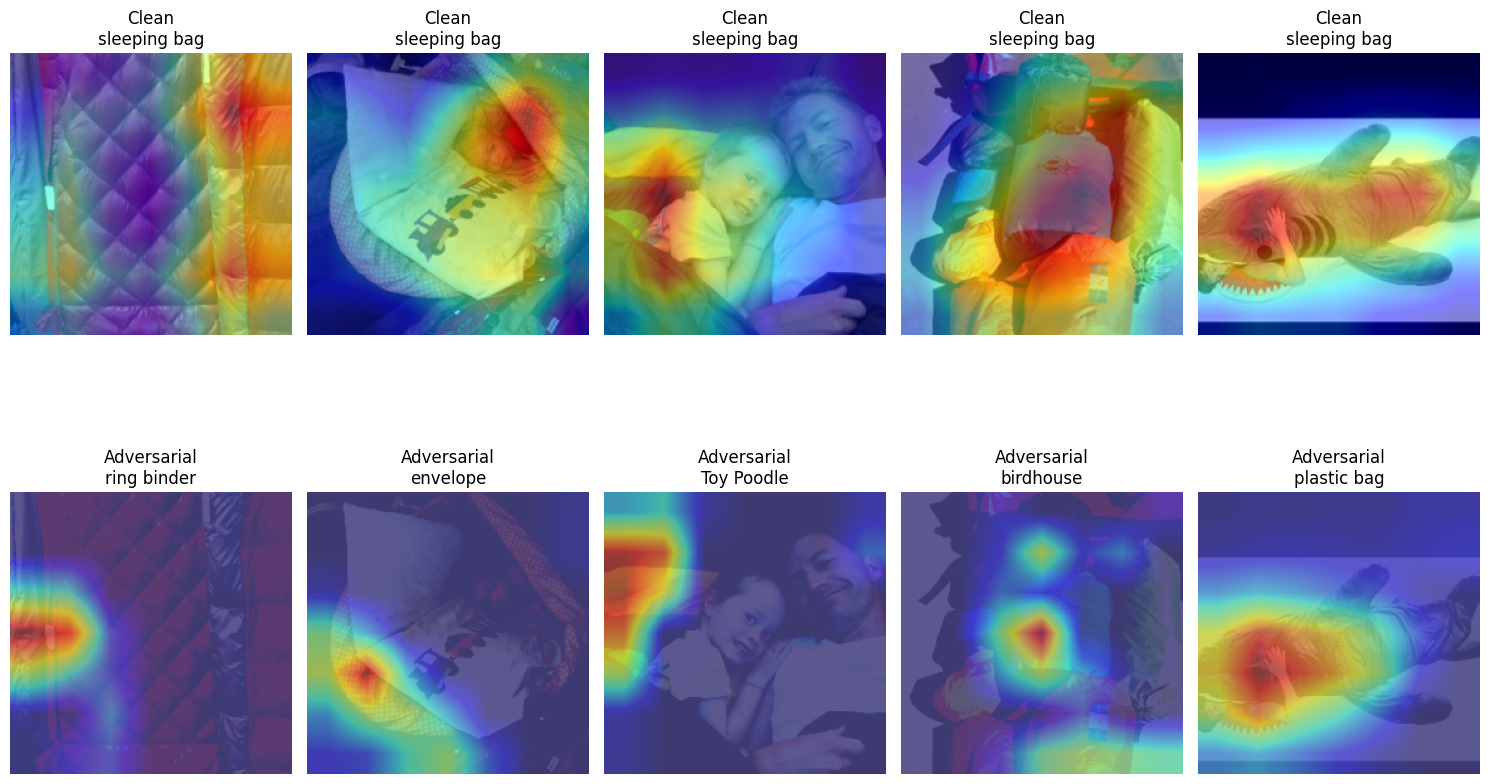

In [69]:
# 5. Visualization function
def plot_gradcam_comparison(clean_images, adv_images, 
                          clean_heatmaps, adv_heatmaps,
                          labels, class_names):
    plt.figure(figsize=(15, 10))
    num_samples = len(clean_images)
    
    for i in range(num_samples):
        # Denormalize images
        denorm = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        
        # Clean image + GradCAM
        plt.subplot(2, num_samples, i+1)
        clean_img = denorm(clean_images[i]).cpu().permute(1, 2, 0).clamp(0, 1)
        plt.imshow(clean_img)
        plt.imshow(clean_heatmaps[i], alpha=0.5, cmap='jet')
        plt.title(f"Clean\n{class_names[labels[i].item()]}")
        plt.axis('off')
        
        # Adversarial image + GradCAM
        plt.subplot(2, num_samples, num_samples+i+1)
        adv_img = denorm(adv_images[i]).cpu().permute(1, 2, 0).clamp(0, 1)
        plt.imshow(adv_img)
        plt.imshow(adv_heatmaps[i], alpha=0.5, cmap='jet')

        with torch.no_grad():
            adv_outputs = model(adv_images[i].unsqueeze(0).to(device))
            _, adv_pred = torch.max(adv_outputs, 1)
        
        plt.title(f"Adversarial\n{class_names[adv_pred.item()]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 6. Run visualization
plot_gradcam_comparison(correct_images, adv_images,
                      clean_heatmaps, adv_heatmaps,
                      correct_labels, class_names=imagenet_classes)

In [70]:
# 7. Quantitative analysis
def analyze_heatmap_changes(clean_heatmaps, adv_heatmaps):
    # Pixel-wise difference
    diffs = (clean_heatmaps - adv_heatmaps).abs().mean(dim=[1,2])
    
    # Attention shift metrics
    clean_max = clean_heatmaps.flatten(1).max(dim=1).indices
    adv_max = adv_heatmaps.flatten(1).max(dim=1).indices
    pos_shift = (clean_max != adv_max).float().mean()
    
    print(f"Mean absolute difference: {diffs.mean().item():.4f}")
    print(f"Attention position changed: {pos_shift.item()*100:.2f}% of cases")

analyze_heatmap_changes(clean_heatmaps, adv_heatmaps)

Mean absolute difference: 0.3095
Attention position changed: 80.00% of cases
